In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import os
from PIL import Image

In [3]:
image1 = Image.open("/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/train/Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG")

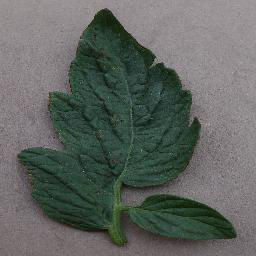

In [4]:
image1

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/train',
                                                       seed=123,shuffle=True,                                                    
                                                       image_size=(128,128),
                                                       batch_size=50
                                                      )

Found 18345 files belonging to 10 classes.


In [7]:
class_labels = train_data.class_names
class_labels

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [10]:
class_size = [len(os.listdir('/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/train/' + name)) for name in class_labels]
class_size

[1702, 1920, 1851, 1882, 1745, 1741, 1827, 1961, 1790, 1926]

In [11]:
test_data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/valid',
                                                       seed=123,shuffle=True,                                                    
                                                       image_size=(128,128),
                                                       batch_size=50
                                                      )

Found 4585 files belonging to 10 classes.


In [12]:
class_labels2 = test_data.class_names
class_labels2

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [14]:
class_size2 = [len(os.listdir('/kaggle/input/tomato/New Plant Diseases Dataset(Augmented)/valid/' + name)) for name in class_labels]
class_size2

[425, 480, 463, 470, 436, 435, 457, 490, 448, 481]

In [15]:
import matplotlib.pyplot as plt

2023-01-31 17:49:53.733929: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


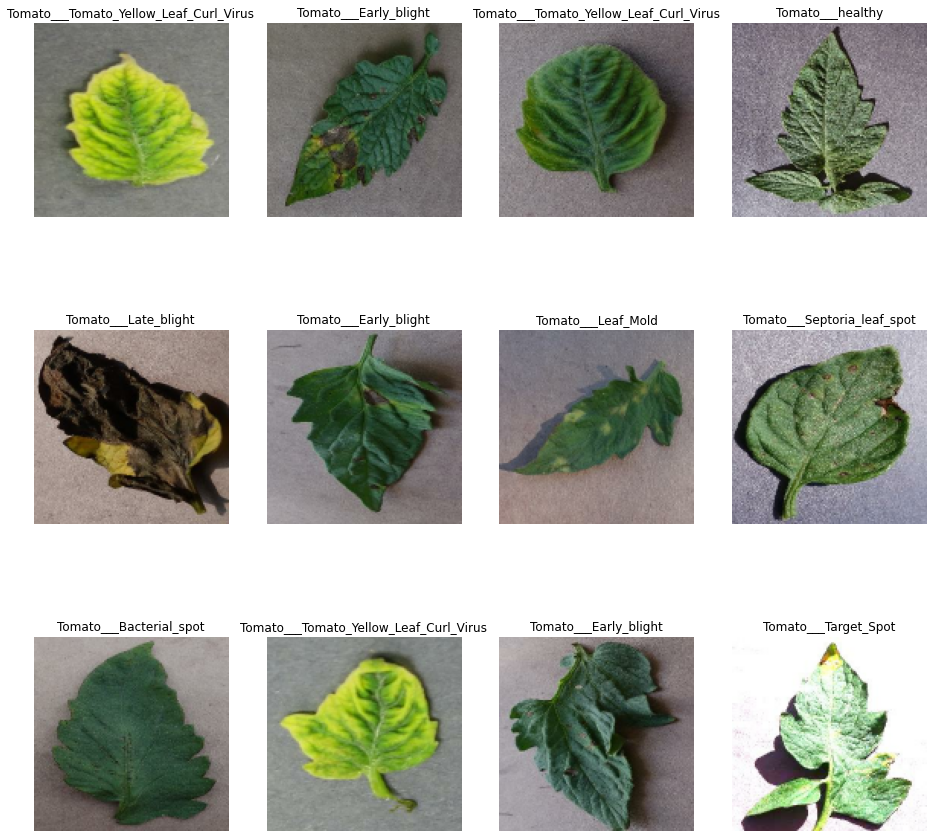

In [16]:
plt.figure(figsize=(16, 16))
for image_batch, labels_batch in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_labels[labels_batch[i]])
        plt.axis("off")

In [17]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [18]:
model = Sequential()

tf.keras.layers.Rescaling(1.0/255)
model.add(Conv2D(128, kernel_size=(3,3),padding='valid',activation='relu',input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(32, kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(16, kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))


model.add(Flatten())

model.add(Dense(1800,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1800,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(900,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        1

In [19]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [22]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
history = model.fit(train_data,batch_size=50, epochs=15, verbose=1,callbacks=[model_checkpoint_callback,es,reduce_lr],
                    validation_data=test_data)

Epoch 1/15


2023-01-31 17:50:56.501191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


367/367 [==============================] - 58s 134ms/step - loss: 1.0038 - accuracy: 0.6664 - val_loss: 1.7236 - val_accuracy: 0.4868
Epoch 2/15
367/367 [==============================] - 26s 71ms/step - loss: 0.5365 - accuracy: 0.8223 - val_loss: 1.1300 - val_accuracy: 0.6443
Epoch 3/15
367/367 [==============================] - 27s 73ms/step - loss: 0.4371 - accuracy: 0.8615 - val_loss: 1.2724 - val_accuracy: 0.6220
Epoch 4/15
367/367 [==============================] - 27s 73ms/step - loss: 0.3518 - accuracy: 0.8860 - val_loss: 1.2229 - val_accuracy: 0.6061
Epoch 5/15
367/367 [==============================] - 27s 71ms/step - loss: 0.3041 - accuracy: 0.9024 - val_loss: 1.9865 - val_accuracy: 0.6938
Epoch 6/15
367/367 [==============================] - 25s 67ms/step - loss: 0.2943 - accuracy: 0.9072 - val_loss: 0.5043 - val_accuracy: 0.8491
Epoch 7/15
367/367 [==============================] - 25s 66ms/step - loss: 0.2834 - accuracy: 0.9150 - val_loss: 0.8206 - val_accuracy: 0.7640
Ep

Let's use AutoTune to see difference

In [25]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
model = Sequential()

tf.keras.layers.Rescaling(1.0/255)
model.add(Conv2D(128, kernel_size=(3,3),padding='valid',activation='relu',input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(32, kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(16, kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))


model.add(Flatten())

model.add(Dense(1800,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1800,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(900,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 128)     3584      
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 128)     512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        73792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)       

In [27]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [28]:
history = model.fit(train_ds,batch_size=50, epochs=50, verbose=1,callbacks=[model_checkpoint_callback,es,reduce_lr],
                    validation_data=test_ds)

Epoch 1/50


2023-01-31 18:01:05.659458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 217 of 1000


  5/367 [..............................] - ETA: 14s - loss: 3.8661 - accuracy: 0.1040   

2023-01-31 18:01:11.681287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


367/367 [==============================] - 35s 49ms/step - loss: 1.0026 - accuracy: 0.6669 - val_loss: 3.0649 - val_accuracy: 0.3304
Epoch 2/50
367/367 [==============================] - 15s 41ms/step - loss: 0.5165 - accuracy: 0.8299 - val_loss: 1.1407 - val_accuracy: 0.6816
Epoch 3/50
367/367 [==============================] - 15s 40ms/step - loss: 0.4341 - accuracy: 0.8594 - val_loss: 3.8264 - val_accuracy: 0.4366
Epoch 4/50
367/367 [==============================] - 15s 40ms/step - loss: 0.3475 - accuracy: 0.8884 - val_loss: 0.8056 - val_accuracy: 0.7614
Epoch 5/50
367/367 [==============================] - 15s 40ms/step - loss: 0.3080 - accuracy: 0.9050 - val_loss: 0.8984 - val_accuracy: 0.7607
Epoch 6/50
367/367 [==============================] - 14s 39ms/step - loss: 0.2935 - accuracy: 0.9085 - val_loss: 1.0153 - val_accuracy: 0.7603
Epoch 7/50
367/367 [==============================] - 15s 40ms/step - loss: 0.2435 - accuracy: 0.9265 - val_loss: 1.1230 - val_accuracy: 0.7791
Epo